In [2]:
import chess
import torch
import util
import chess
import pickle
from sigmazero import mcts, Node
import pandas as pd
from copy import deepcopy

In [3]:
games_csv = pd.read_csv('./data/chess_games.csv')

In [5]:
# check if elos above 2000
elos = games_csv[(games_csv['WhiteElo'] > 2000)]

In [12]:
# print column names
print(games_csv.columns)

Index(['Event', 'White', 'Black', 'Result', 'UTCDate', 'UTCTime', 'WhiteElo',
       'BlackElo', 'WhiteRatingDiff', 'BlackRatingDiff', 'ECO', 'Opening',
       'TimeControl', 'Termination', 'AN'],
      dtype='object')


In [4]:
# filter moves by rating threshold and no draws
games = games_csv[(games_csv['Result'] != '1/2-1/2') & (games_csv['Result'] != '*') & (games_csv['WhiteElo'] > 2300) & (games_csv['WhiteElo'] < 2310)]
print(len(games))
# reindex



8771


In [5]:
games = games.reset_index(drop=True)

moves = games['AN']
winners = games['Result']


In [15]:
board = chess.Board()
game1 = games['AN'][0]

In [ ]:
board.par

In [14]:
# split and check if move is legal
for move in game1.split():
    if chess.Move.from_uci(move) in board.legal_moves:
        board.push(chess.Move.from_uci(move))
    else:
        print('illegal move')
        break

InvalidMoveError: invalid san: '1.'

In [5]:
games_csv = None

In [6]:
len(moves)

16683

In [6]:
# loop through each game
states = []
values = []
board_fens = []
file_index = 1
positions = 1
for i in range(len(moves)):

    # if i % 2500 == 0 and i != 0:
    #     # save states and values
    #     pickle.dump(lichess_1800_states, open('./data/lichess_1200_states' + str(file_index) + '.pkl', 'wb'))
    #     pickle.dump(lichess_1800_values, open('./data/lichess_1200_values' + str(file_index) + '.pkl', 'wb'))
    #     lichess_1800_states.clear()
    #     lichess_1800_values.clear()
    #     file_index += 1
    #     print('saving ' + str(file_index))

    print(f'{i/len(moves)*100:.5f}%', end='\r')
    game = moves[i]
    winner = True if winners[i] == '1-0' else False
    board = chess.Board()
    move_num = 1
    for move in game.split():
        
        try:
            board.parse_san(move)
        except:
            continue

        board_fens.append(board.board_fen())

        board.push_san(move)

        states.append(util.one_hot_board(util.board_to_list(board)).unsqueeze(0))

        
            
        #state[0][13] += (1.0 / move_num)
        #state[0][13] *= (1.0 if board.turn == True else -1.0)
        # lichess_1800_states.append(state)
        
        #values.append(torch.tensor([1.0 if winner else -1.0]))
        values.append(torch.tensor([-(board.turn * 2.0 - 1.0)]))

        # check if move string is valid
        
        if positions % 512 == 0:
            states = torch.stack(states)
            values = torch.stack(values)
            batch = (states, values, board_fens)
            torch.save(batch, f'./data/ahhv2/batch2200_{file_index}.pt')
            file_index += 1

            states = []
            values = []
            board_fens = []

        
        positions += 1

        move_num += 1

states = torch.stack(states)
values = torch.stack(values)
batch = (states, values)
torch.save(batch, f'./data/ahhv2/batch2200_{file_index}.pt')

states = []
values = []

# pickle.dump(lichess_1800_states, open('./data/lichess_1200_states' + str(file_index) + '.pkl', 'wb'))
# pickle.dump(lichess_1800_values, open('./data/lichess_1200_values' + str(file_index) + '.pkl', 'wb'))
# lichess_1800_states.clear()
# lichess_1800_values.clear()

In [7]:
class ChessDataset(torch.utils.data.Dataset):
    def __init__(self):
        # self.states = states
        # self.values = values
        pass
    def __len__(self):
        return 1180

    def __getitem__(self, idx):
        return torch.load(f'./data/ahhv2/batch2200_{idx+1}.pt')

In [8]:
deeta = ChessDataset()

In [9]:
import torch
from torch import nn
from sigmazero import ValueNetwork, SimpleValueNetwork
import pickle
import torchsummary
import random

In [19]:
# lichess_1800_states = pickle.load(open('./data/lichess_1800_states.pkl', 'rb'))
# lichess_1800_values = pickle.load(open('./data/lichess_1800_values.pkl', 'rb'))

# shuffle
import random
c = list(zip(lichess_1800_states, lichess_1800_values))
random.shuffle(c)
lichess_1800_states, lichess_1800_values = zip(*c)


In [62]:
lichess_1800_states = pickle.load(open('./data/lichess_1800_states.pkl', 'rb'))
lichess_1800_values = pickle.load(open('./data/lichess_1800_values.pkl', 'rb'))

In [20]:
pickle.dump(lichess_1800_states, open('./data/lichess_1600_states.pkl', 'wb'))
pickle.dump(lichess_1800_values, open('./data/lichess_1600_values.pkl', 'wb'))

In [10]:
DEVICE = "cuda"

In [185]:
nnet = nnet.to(DEVICE)

In [16]:
nnet = SimpleValueNetwork().to(DEVICE)
#nnet.load_state_dict(torch.load('./models/lichess_2200_simplevaluenet.pth'))
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.0001)
criterion = nn.MSELoss().to(DEVICE)

In [19]:
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.00001)

In [13]:
BATCH_SIZE = 512

In [91]:
batches = []
for i in range(0, len(lichess_1800_states), BATCH_SIZE):
    batches.append((torch.cat(lichess_1800_states[i:i+BATCH_SIZE]).squeeze(), torch.cat(lichess_1800_values[i:i+BATCH_SIZE])))

In [9]:
# clear memory
lichess_1800_states = None
lichess_1800_values = None

In [12]:
import random

In [13]:
losses = []

In [17]:
# load all batches
batches = []

for pickles in range(1, 3):
    lichess_1800_states = pickle.load(open('./data/lichess_1200_states' + str(pickles) + '.pkl', 'rb'))
    lichess_1800_values = pickle.load(open('./data/lichess_1200_values' + str(pickles) + '.pkl', 'rb'))


    for i in range(0, len(lichess_1800_states), BATCH_SIZE):
        batches.append((torch.cat(lichess_1800_states[i:i+BATCH_SIZE]).squeeze(), torch.cat(lichess_1800_values[i:i+BATCH_SIZE])))
    # shuffle batches

In [20]:
deeta[4][2].shape

IndexError: tuple index out of range

In [14]:
# make dataloader
dataloader = torch.utils.data.DataLoader(deeta, batch_size=1, shuffle=True)

In [16]:
# check each batch
for i, batch in enumerate(dataloader):
    #print(i, batch[0].shape, batch[1].shape, batch[2])
    try:
        batch[2]
    except:
        print(i)
    

KeyboardInterrupt: 

In [17]:
for epoch in range(10000):
    for i, batch in enumerate(dataloader):

        for j in range(1):
            loss2 = 0
            negative_states = []
            negative_values = []
            for cheese in batch[2]:
                board = chess.Board(cheese[0])
                legalmoves = list(board.legal_moves)
                if board.is_game_over():
                    negative_states.append(util.one_hot_board(util.board_to_list(board)).unsqueeze(0))
                    negative_values.append(torch.tensor([-(board.turn * 2 - 1)]))
                    continue
                board.push(random.choice(legalmoves))
                negative_states.append(util.one_hot_board(util.board_to_list(board)).unsqueeze(0))
                negative_values.append(torch.tensor([(board.turn * 2 - 1)]))

            negative_states = torch.stack(negative_states)
            # negative_values = torch.stack(negative_values)

            negative_states = negative_states.to(DEVICE)
            negative_states = negative_states.squeeze().reshape(-1, 832)
            # negative_values = negative_values.to(DEVICE)
            # pred2 = nnet(negative_states)

            # #p#rint(pred)
            # optimizer.zero_grad() 
            # loss2 = criterion(pred2.squeeze(), negative_values.squeeze().squeeze())
            
              
            # loss2.backward()
            # optimizer.step()
            #losses.append(loss2.item())

            state = batch[0].to(DEVICE)
            state = state.squeeze().reshape(-1, 832)
            value = batch[1].to(DEVICE)
            pred1 = nnet(state)

            #p#rint(pred)
            loss1 = criterion(pred1.squeeze(), value.squeeze().squeeze())
            # optimizer.zero_grad()
            # loss1.backward()
            # optimizer.step()
            

            lastloss = (-((nnet(state).squeeze() - nnet(negative_states).squeeze())**2.0)+1.0).mean()
            lass = lastloss*.05 + loss1
            optimizer.zero_grad()
            lass.backward()
            optimizer.step()
            losses.append(loss1.item() + lastloss.item())
            
            # optimizer.zero_grad()
            # loss.backward()
            # optimizer.step()
            # losses.append(loss.item())

            

            if len(losses) > 100:
                losses.pop(0)
            avg_loss = sum(losses) / len(losses)
            print(f'Epoch: {epoch}, Batch Percent: {i/len(deeta)*100:.2f}%, lastloss: {lastloss.item()} Loss1: {loss1.item()} Avg Loss: {avg_loss}', end='\r')

In [13]:
# save model
torch.save(nnet.state_dict(), './models/lichess_2200_simplevaluenet.pth')

In [21]:
import chess
import util

In [22]:
nnet = nnet.to("cpu")

In [23]:
test_board = chess.Board()

In [40]:
test_board.push_san("Nc3")

Move.from_uci('b1c3')

In [11]:
state = util.one_hot_board(util.board_to_list(test_board)).unsqueeze(0)
            
# state[0][13] += (1.0 / 1)
# state[0][13] *= (1.0 if test_board.turn == True else -1.0)

value = nnet(state)
value

tensor([[0.2658]], grad_fn=<TanhBackward0>)

In [79]:
test_board.push_san("Qh5")

Move.from_uci('d1h5')

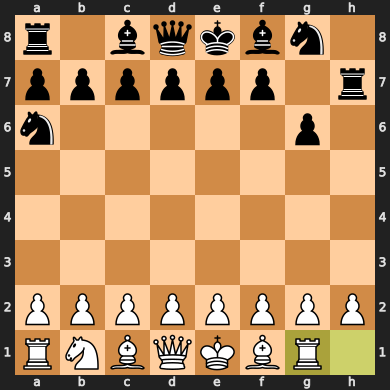

In [19]:
test_board

In [89]:
nnet.load_state_dict(torch.load('./models/lichess_1800.pth'))

<All keys matched successfully>

In [115]:
move_num = 4

In [28]:
test_board = chess.Board()

tensor([[0.4702]], grad_fn=<TanhBackward0>)
g8h6 0.39 g8f6 -0.44 b8c6 0.37 b8a6 0.95 b6h6 0.90 b6g6 -0.11 b6f6 0.82 b6e6 0.35 b6d6 0.72 b6c6 0.49 b6a6 0.44 b6b5 0.30 h7h6 0.74 g7g6 0.82 f7f6 0.78 e7e6 0.08 d7d6 0.59 c7c6 0.54 a5a4 0.77 h7h5 0.31 g7g5 0.49 f7f5 0.10 e7e5 0.63 d7d5 0.46 c7c5 0.67 

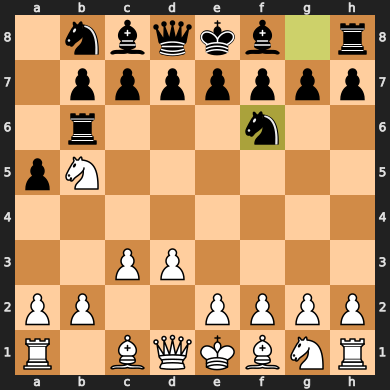

In [36]:
# value every move
legal_moves = list(test_board.legal_moves)
def eval_move(move):
    test_board.push(move)
    state = util.one_hot_board(util.board_to_list(test_board)).unsqueeze(0)
            
    state[0][13] += (1.0 / 2)
    state[0][13] *= (1.0 if test_board.turn == True else -1.0)

    value = nnet(state)
    test_board.pop()
    return -value

values = []

state = util.one_hot_board(util.board_to_list(test_board)).unsqueeze(0)
            
    # state[0][13] += (1.0 / 2)
    # state[0][13] *= (1.0 if test_board.turn == True else -1.0)
state = state[:, :13, :, :]
print(nnet(state))
    

for move in legal_moves:
    test_board.push(move)
    state = util.one_hot_board(util.board_to_list(test_board)).unsqueeze(0)
            
    # state[0][13] += (1.0 / 2)
    # state[0][13] *= (1.0 if test_board.turn == True else -1.0)
    state = state[:, :13, :, :]
    value = nnet(state)
    values.append(value.item())
    print(move, f"{value.item():.2f}", end=" ")
    test_board.pop()

# get index of max
if test_board.turn == True:
    max_index = values.index(max(values))
else:
    max_index = values.index(min(values))


# move = mcts(Node(test_board), test_board, nnet, 800, move_num, "cpu", True)
test_board.push(legal_moves[max_index])
# print(move)
# move_num += 1
# test_board
test_board

In [48]:
test_board.push_san("g8f6")

Move.from_uci('g8f6')

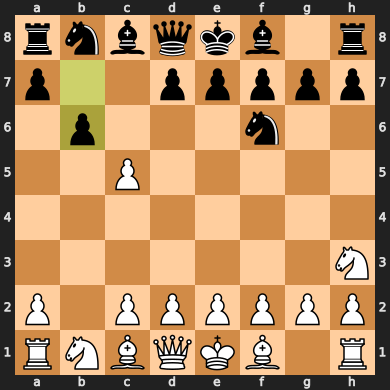